In [3]:
import torch, os, datetime, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms 
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random
import pandas as pd
import time
from sklearn.metrics import precision_score, recall_score, f1_score

import seaborn as sns

In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Carregando e seperando dataset

In [4]:
batch_size = 32

# Transformações para normalizar o dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Carregando o dataset MNIST
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# DataLoader para o dataset de treinamento e teste
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

classes = list(map(str, range(0, 10)))

##### Visualizando dados

In [5]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


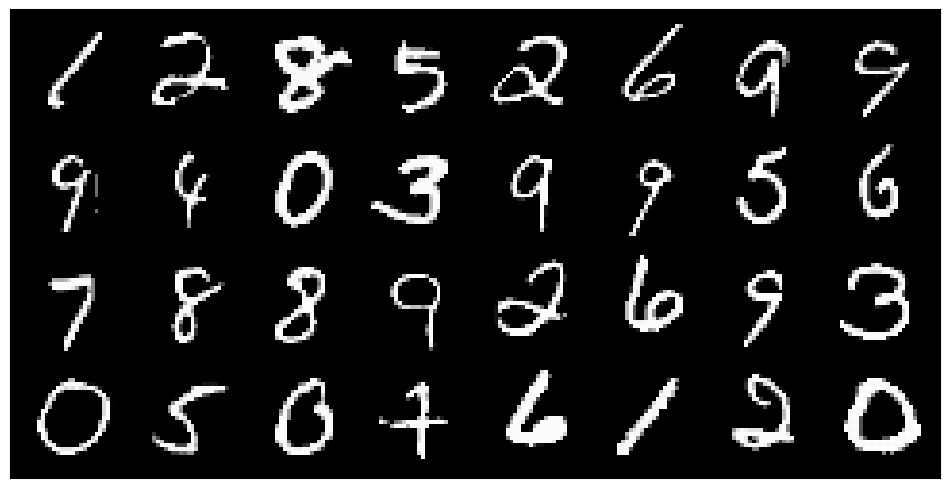

In [6]:
show_batch(trainloader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


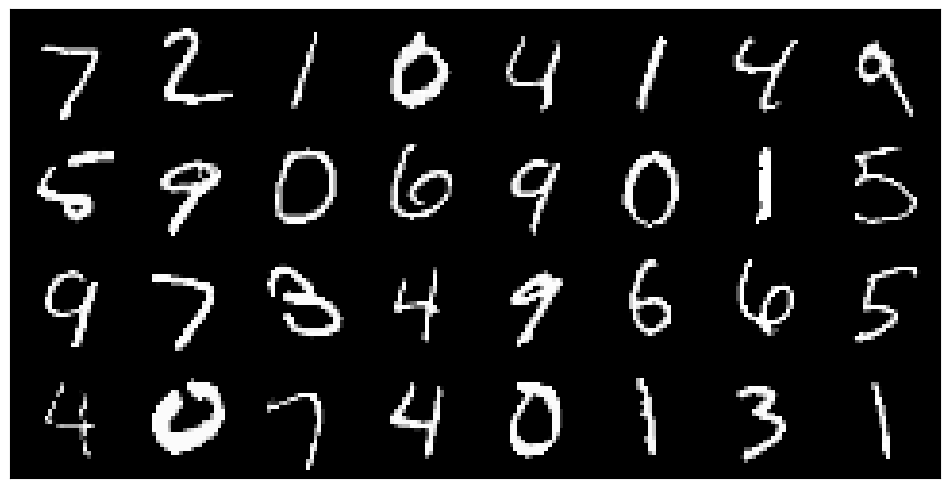

In [7]:
show_batch(testloader)

## Criando uma instância da classe nn.Module para criar redes

#### Explicando cada parâmetro da camada convolucional:

- **in_channels**: Quantos canais de cores os inputs possuem. No caso de imagens em preto e branco, como estamos trabalhando com MNIST, há apenas um canal de cor.

- **out_channels**: Número de filtros (kernels) que serão aplicados à imagem durante a convolução. Cada filtro é responsável por extrair características latentes da imagem.

- **kernel_size**: Dimensão do filtro utilizado na convolução. O valor comum de 3 é amplamente usado, pois é suficiente para capturar detalhes locais, ao mesmo tempo em que percebe padrões maiores na imagem.

- **stride**: Indica de quanto em quantos pixels o filtro será aplicado na imagem.

- **padding**: Adiciona pixels em volta da imagem de entrada durante a convolução para garantir que o tamanho da saída após a convolução permaneça o mesmo que o da entrada.
  - *Observação*: Ao adicionar padding, é preciso ter cuidado com os valores para garantir que a resolução e o tamanho da imagem não sejam afetados de forma indesejada.

- **dropout_prob**: Probabilidade de que um neurônio seja desligado durante o treinamento da rede. Isso é uma técnica de regularização que ajuda a prevenir o overfitting, forçando a rede a aprender representações mais robustas e generalizáveis.

#### Fórmulas das Dimensões de Saída

A fórmula para calcular a dimensão de saída \( W_out \) da convolução é:

$$
W_{\text{out}} = \left\lfloor \frac{W_{\text{in}} + 2 \times \text{padding} - \text{kernel\_size}}{\text{stride}} \right\rfloor + 1
$$

E a fórmula para calcular a dimensão de saída \( H_out \) da convolução é:

$$
H_{\text{out}} = \left\lfloor \frac{H_{\text{in}} + 2 \times \text{padding} - \text{kernel\_size}}{\text{stride}} \right\rfloor + 1
$$

Resumindo as trasnformações:

- Entrada Original: 28x28 pixels, 1 canal.
- Após Convolução: 28x28 pixels, 32 canais.
- Após Pooling: 14x14 pixels, 32 canais.
- Entrada para self.fc1: 32 × 14 × 14

In [8]:
class BaseCNN(nn.Module):
    def __init__(self, conv_kernel_size=3, conv_stride=1, conv_padding=1, pool_kernel_size=2, pool_stride=2, dropout_prob=0.5):
        super(BaseCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=conv_kernel_size, stride=conv_stride, padding=conv_padding)
        self.pool = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=pool_stride)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc1 = nn.Linear(32 * 14 * 14, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(-1, 32 * 14 * 14)
        x = self.fc1(x)
        return x

In [9]:
class DeepCNN(nn.Module):
    def __init__(self, conv_kernel_size=3, conv_stride=1, conv_padding=1, pool_kernel_size=2, pool_stride=2, dropout_prob=0.5):
        super(DeepCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=conv_kernel_size, stride=conv_stride, padding=conv_padding)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=conv_kernel_size, stride=conv_stride, padding=conv_padding)
        self.pool = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=pool_stride)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [12]:
class CNN(nn.Module):
    def __init__(self, trial, num_conv_layers, num_filters, num_neurons, drop_conv2, drop_prob_fc1):
        super(CNN, self).__init__()

        in_size = 28
        conv_kernel_size = 3
        # conv_kernel_stride
        pool_kernel_size = 2
        # pool_stride

        # TODO(pedro): Try to make both the conv and pool kernel sizes constructor parameters.

        self.convs = nn.ModuleList([nn.Conv2d(1, num_filters[0],
                                              kernel_size=(conv_kernel_size, conv_kernel_size))])
        out_size = int((in_size - conv_kernel_size + 1) / 2)

        for i in range(1, num_conv_layers):
            self.convs.append(nn.Conv2d(in_channels=num_filters[i - 1], out_channels=num_filters[i],
                                        kernel_size=(conv_kernel_size, conv_kernel_size)))
            out_size = int((out_size - conv_kernel_size + 1) / 2)

        self.conv2_drop = nn.Dropout2d(p=drop_conv2)
        self.out_feature = num_filters[num_conv_layers - 1] * out_size * out_size
        self.pool = nn.MaxPool2d(kernel_size=pool_kernel_size)
        self.fc1 = nn.Linear(self.out_feature, num_neurons)
        self.fc2 = nn.Linear(num_neurons, 10)
        self.fc1_drop_prob = drop_prob_fc1

    def forward(self, x):
        for i, conv in enumerate(self.convs):
            x = conv(x)
            if i == 2:
                x = self.conv2_drop(x)
            x = F.relu(self.pool(x))

        x = x.view(-1, self.out_feature)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.fc1_drop_prob, training=self.training)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

# Definindo funções úteis

#### Função de treinamento do modelo

In [37]:
def train_model(model, criterion, optimizer, epochs):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0

        for i, (inputs, labels) in enumerate(trainloader):
            (inputs, labels) = (inputs.to(device), labels.to(device))
            optimizer.zero_grad()
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()  # Propaga os gradientes
            optimizer.step()  # Atualiza os pesos

            running_loss += loss.item()

            if (i + 1) % 100 == 0:
                print(f'Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{len(trainloader)}], Loss: {running_loss / len(trainloader)}')
    
    print('Finished Training!')

#### Função de teste do modelo

In [28]:
def test_model(model, criterion):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = correct / total
    loss = test_loss / len(testloader)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    return accuracy, loss, precision, recall, f1

#### Função de acurácia de cada classe

In [47]:
# Mudar
def accuracy_classes(model_trained):
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    all_accuracy = []

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_trained(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        all_accuracy.append(accuracy)
    
    return all_accuracy

#### Função para prever classe de uma imagem

In [17]:
def predict_image(image_path, model):
    image = Image.open(image_path).convert('L')  
    transform = transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor()
    ])

    # Adiciona dimensão de batch (1 imagem)
    image = transform(image).unsqueeze(0) 

    # Passando a imagem pela rede
    output = model(image).to(device)

    _, predicted_class = torch.max(output, 1)
    print("Classe prevista:", predicted_class.item())


#### Definindo cvs com os parametros e metricas

In [18]:
if (os.path.exists('cnn_models_metrics.csv')):
    model_df = pd.read_csv('cnn_models_metrics.csv')
else:
    model_data = {
        'network': [],
        'conv_kernel_size': [],
        'conv_stride': [],
        'conv_padding': [],
        'pool_kernel_size': [],
        'pool_stride': [],
        'dropout_prob': [],
        'fit_time': [],
        'precision': [],
        'recall': [],
        'f1_score': [],
        'overall_accuracy ': [],
        'accuracy_0': [],
        'accuracy_1': [],
        'accuracy_2': [],
        'accuracy_3': [],
        'accuracy_4': [],
        'accuracy_5': [],
        'accuracy_6': [],
        'accuracy_7': [],
        'accuracy_8': [],
        'accuracy_9': [],
        'total_epochs': [],
        'learning_rate': [],
    }
    model_df = pd.DataFrame(model_data)

# Optuna

In [52]:
num_epochs = 15
num_trials = 10
criterion = nn.CrossEntropyLoss().to(device)

# TODO(pedro): Try to generate different types of criterion inside the objective function.

# TODO(pedro): Factor out this function eventually.
def train_model_once(model, criterion, optimizer):
    model.train().to(device)

    running_loss = 0.0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()  # Propaga os gradientes
        optimizer.step()  # Atualiza os pesos

        running_loss += loss.item()
 
    return running_loss / len(trainloader)

import optuna
from optuna.trial import TrialState

def objective(trial):
    # Define range of values to be tested for the hyperparameters
    num_conv_layers = trial.suggest_int("num_conv_layers", 1, 3)
    num_filters = [int(trial.suggest_discrete_uniform("num_filter_" + str(i), 16, 128, 16))
                   for i in range(num_conv_layers)]
    num_neurons = trial.suggest_int("num_neurons", 10, 400, 10)  # Number of neurons of fully connected layer 1
    drop_conv2 = trial.suggest_float("drop_conv2", 0.2, 0.5)     # Dropout for convolutional layer 2
    drop_fc1 = trial.suggest_float("drop_prob_fc1", 0.2, 0.5)    # Dropout probability for fully connected layer 1

    # Generate the model
    model = CNN(trial, num_conv_layers, num_filters, num_neurons, drop_conv2,  drop_fc1).to(device)

    # Generate the optimizer
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # Train the model
    for epoch in range(num_epochs):
        train_loss = train_model_once(model, criterion, optimizer)
        accuracy, test_loss, precision, recall, f1 = test_model(model, criterion)

        print(f"Epoch {epoch + 1}, " +
              f"Train Loss: {train_loss:.4f}, " + 
              f"Test Loss: {test_loss:.4f}")

        # Pruning (stops trial early if not promising)
        trial.report(accuracy, epoch)
        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    trial.set_user_attr("accuracy", test_loss)
    trial.set_user_attr("test_loss", test_loss)
    trial.set_user_attr("precision", precision)
    trial.set_user_attr("recall", recall)
    trial.set_user_attr("f1_score", f1)

    current_datetime = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
    path_model_trained = os.path.join('modelos_treinados', f'optune{current_datetime}.pth')
    torch.save(model.state_dict(), path_model_trained)

    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("\n-- Study Statistics --")
print(f"  Number of finished trials: {len(study.trials)}")
print(f"  Number of pruned trials:   {len(pruned_trials)}")
print(f"  Number of complete trials: {len(complete_trials)}")

best_trial = study.best_trial
print("\n-- Best Trial --")
print(f"  Accuracy:  {best_trial.value}")
print(f"  Test Loss: {best_trial.user_attrs['test_loss']}")
print(f"  Precision: {best_trial.user_attrs['precision']}")
print(f"  Recall:    {best_trial.user_attrs['recall']}")
print(f"  F1 Score:  {best_trial.user_attrs['f1_score']}")
print("  Parameters: ")
for key, val in best_trial.params.items():
    print(f"    {key}: {(15 - len(key)) * ' '}{val}")

# Save results to csv file
df = study.trials_dataframe().drop(["datetime_start", "datetime_complete", "duration"], axis=1)
df = df.loc[df["state"] == "COMPLETE"]  # Keep only results that did not prune
df = df.drop("state", axis=1)
df = df.sort_values("value")            # Sort based on accuracy
df.to_csv("optuna_results.csv", index=False)

print(f"\n-- Overall Results (Ordered by Accuracy) --")
print(df)

most_important_parameters = optuna.importance.get_param_importances(study, target=None)

print("\n-- Most Important Hyperparameters --")
for key, val in most_important_parameters.items():
    print(f"  {key}: {(15 - len(key)) * ' '}{(100 * val):.2f}%")

[I 2024-05-21 18:15:23,312] A new study created in memory with name: no-name-57bf0262-1893-4ef3-82b7-5318f7ab68ea
/tmp/ipykernel_4782/987582870.py:32: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_" + str(i), 16, 128, 16))
/tmp/ipykernel_4782/987582870.py:34: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_neurons = trial.suggest_int("num_neurons", 10, 400, 10)  # Number of neurons of fully connected layer 1


Epoch 1, Train Loss: 0.7951, Test Loss: 0.2706
Epoch 2, Train Loss: 0.2604, Test Loss: 0.1594
Epoch 3, Train Loss: 0.1765, Test Loss: 0.1147
Epoch 4, Train Loss: 0.1372, Test Loss: 0.0893
Epoch 5, Train Loss: 0.1128, Test Loss: 0.0753
Epoch 6, Train Loss: 0.0973, Test Loss: 0.0677
Epoch 7, Train Loss: 0.0851, Test Loss: 0.0574
Epoch 8, Train Loss: 0.0765, Test Loss: 0.0527
Epoch 9, Train Loss: 0.0693, Test Loss: 0.0491
Epoch 10, Train Loss: 0.0643, Test Loss: 0.0462
Epoch 11, Train Loss: 0.0596, Test Loss: 0.0431
Epoch 12, Train Loss: 0.0557, Test Loss: 0.0412
Epoch 13, Train Loss: 0.0532, Test Loss: 0.0394
Epoch 14, Train Loss: 0.0502, Test Loss: 0.0379


[I 2024-05-21 18:20:28,636] Trial 0 finished with value: 0.988 and parameters: {'num_conv_layers': 2, 'num_filter_0': 112.0, 'num_filter_1': 32.0, 'num_neurons': 170, 'drop_conv2': 0.22862215615696302, 'drop_prob_fc1': 0.26494362538264593, 'optimizer': 'RMSprop', 'lr': 2.1267869176461055e-05}. Best is trial 0 with value: 0.988.


Epoch 15, Train Loss: 0.0473, Test Loss: 0.0370


/tmp/ipykernel_4782/987582870.py:32: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_" + str(i), 16, 128, 16))
/tmp/ipykernel_4782/987582870.py:34: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_neurons = trial.suggest_int("num_neurons", 10, 400, 10)  # Number of neurons of fully connected layer 1


Epoch 1, Train Loss: 0.2043, Test Loss: 0.0628
Epoch 2, Train Loss: 0.0604, Test Loss: 0.0344
Epoch 3, Train Loss: 0.0436, Test Loss: 0.0256
Epoch 4, Train Loss: 0.0328, Test Loss: 0.0231
Epoch 5, Train Loss: 0.0266, Test Loss: 0.0238
Epoch 6, Train Loss: 0.0215, Test Loss: 0.0278
Epoch 7, Train Loss: 0.0189, Test Loss: 0.0218
Epoch 8, Train Loss: 0.0154, Test Loss: 0.0204
Epoch 9, Train Loss: 0.0130, Test Loss: 0.0202
Epoch 10, Train Loss: 0.0104, Test Loss: 0.0247
Epoch 11, Train Loss: 0.0100, Test Loss: 0.0196
Epoch 12, Train Loss: 0.0091, Test Loss: 0.0251
Epoch 13, Train Loss: 0.0069, Test Loss: 0.0310
Epoch 14, Train Loss: 0.0065, Test Loss: 0.0257


[I 2024-05-21 18:25:02,592] Trial 1 finished with value: 0.9938 and parameters: {'num_conv_layers': 2, 'num_filter_0': 112.0, 'num_filter_1': 96.0, 'num_neurons': 400, 'drop_conv2': 0.4879431809139045, 'drop_prob_fc1': 0.413034487730109, 'optimizer': 'Adam', 'lr': 0.00015696059338384257}. Best is trial 1 with value: 0.9938.


Epoch 15, Train Loss: 0.0062, Test Loss: 0.0207


/tmp/ipykernel_4782/987582870.py:32: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_" + str(i), 16, 128, 16))
/tmp/ipykernel_4782/987582870.py:34: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_neurons = trial.suggest_int("num_neurons", 10, 400, 10)  # Number of neurons of fully connected layer 1
/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1, Train Loss: 2.2814, Test Loss: 2.2411


/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2, Train Loss: 2.1090, Test Loss: 1.7385
Epoch 3, Train Loss: 1.4216, Test Loss: 0.8281
Epoch 4, Train Loss: 0.8350, Test Loss: 0.4427
Epoch 5, Train Loss: 0.5862, Test Loss: 0.3095
Epoch 6, Train Loss: 0.4675, Test Loss: 0.2444
Epoch 7, Train Loss: 0.4047, Test Loss: 0.2124
Epoch 8, Train Loss: 0.3547, Test Loss: 0.1834
Epoch 9, Train Loss: 0.3221, Test Loss: 0.1629
Epoch 10, Train Loss: 0.2940, Test Loss: 0.1515
Epoch 11, Train Loss: 0.2764, Test Loss: 0.1419
Epoch 12, Train Loss: 0.2621, Test Loss: 0.1321
Epoch 13, Train Loss: 0.2488, Test Loss: 0.1286
Epoch 14, Train Loss: 0.2360, Test Loss: 0.1203


[I 2024-05-21 18:29:06,808] Trial 2 finished with value: 0.9668 and parameters: {'num_conv_layers': 3, 'num_filter_0': 96.0, 'num_filter_1': 80.0, 'num_filter_2': 32.0, 'num_neurons': 220, 'drop_conv2': 0.20171172787227468, 'drop_prob_fc1': 0.319592819115777, 'optimizer': 'SGD', 'lr': 0.0012838130023360144}. Best is trial 1 with value: 0.9938.


Epoch 15, Train Loss: 0.2257, Test Loss: 0.1142


/tmp/ipykernel_4782/987582870.py:32: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_" + str(i), 16, 128, 16))
/tmp/ipykernel_4782/987582870.py:34: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_neurons = trial.suggest_int("num_neurons", 10, 400, 10)  # Number of neurons of fully connected layer 1


Epoch 1, Train Loss: 0.2551, Test Loss: 0.0671
Epoch 2, Train Loss: 0.0879, Test Loss: 0.0489
Epoch 3, Train Loss: 0.0661, Test Loss: 0.0374
Epoch 4, Train Loss: 0.0543, Test Loss: 0.0372
Epoch 5, Train Loss: 0.0479, Test Loss: 0.0304
Epoch 6, Train Loss: 0.0408, Test Loss: 0.0313
Epoch 7, Train Loss: 0.0360, Test Loss: 0.0306
Epoch 8, Train Loss: 0.0337, Test Loss: 0.0266
Epoch 9, Train Loss: 0.0300, Test Loss: 0.0259
Epoch 10, Train Loss: 0.0287, Test Loss: 0.0278
Epoch 11, Train Loss: 0.0258, Test Loss: 0.0272
Epoch 12, Train Loss: 0.0243, Test Loss: 0.0263
Epoch 13, Train Loss: 0.0229, Test Loss: 0.0305
Epoch 14, Train Loss: 0.0197, Test Loss: 0.0283


[I 2024-05-21 18:32:42,026] Trial 3 finished with value: 0.991 and parameters: {'num_conv_layers': 2, 'num_filter_0': 64.0, 'num_filter_1': 16.0, 'num_neurons': 110, 'drop_conv2': 0.4547032939983268, 'drop_prob_fc1': 0.32946432046532914, 'optimizer': 'SGD', 'lr': 0.05330073613710872}. Best is trial 1 with value: 0.9938.


Epoch 15, Train Loss: 0.0196, Test Loss: 0.0287


/tmp/ipykernel_4782/987582870.py:32: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_" + str(i), 16, 128, 16))
/tmp/ipykernel_4782/987582870.py:34: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_neurons = trial.suggest_int("num_neurons", 10, 400, 10)  # Number of neurons of fully connected layer 1
/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1, Train Loss: 2.9297, Test Loss: 2.3053


/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2, Train Loss: 2.3091, Test Loss: 2.3052


/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3, Train Loss: 2.3096, Test Loss: 2.3115


/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4, Train Loss: 2.3098, Test Loss: 2.3107


/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5, Train Loss: 2.3097, Test Loss: 2.3033


/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 6, Train Loss: 2.3098, Test Loss: 2.3057


/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 7, Train Loss: 2.3095, Test Loss: 2.3118


/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 8, Train Loss: 2.3094, Test Loss: 2.3071


/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 9, Train Loss: 2.3090, Test Loss: 2.3145


/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 10, Train Loss: 2.3098, Test Loss: 2.3127


/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 11, Train Loss: 2.3097, Test Loss: 2.3107


/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 12, Train Loss: 2.3094, Test Loss: 2.3092


/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 13, Train Loss: 2.3095, Test Loss: 2.3159


/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 14, Train Loss: 2.3100, Test Loss: 2.3032


/home/guilhermemaciel/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
[I 2024-05-21 18:36:50,461] Trial 4 finished with value: 0.0982 and parameters: {'num_conv_layers': 1, 'num_filter_0': 112.0, 'num_neurons': 90, 'drop_conv2': 0.22362703618229485, 'drop_prob_fc1': 0.38786225611913094, 'optimizer': 'Adam', 'lr': 0.06469964401114069}. Best is trial 1 with value: 0.9938.
/tmp/ipykernel_4782/987582870.py:32: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_" + str(i), 16, 128, 16))
/tmp/ipykernel_4782/9875

Epoch 15, Train Loss: 2.3100, Test Loss: 2.3062


[I 2024-05-21 18:37:07,169] Trial 5 pruned. 


Epoch 1, Train Loss: 2.0217, Test Loss: 1.2398


/tmp/ipykernel_4782/987582870.py:32: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_" + str(i), 16, 128, 16))
/tmp/ipykernel_4782/987582870.py:34: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_neurons = trial.suggest_int("num_neurons", 10, 400, 10)  # Number of neurons of fully connected layer 1


Epoch 1, Train Loss: 0.4352, Test Loss: 0.1151
Epoch 2, Train Loss: 0.1145, Test Loss: 0.0714
Epoch 3, Train Loss: 0.0829, Test Loss: 0.0549
Epoch 4, Train Loss: 0.0670, Test Loss: 0.0472
Epoch 5, Train Loss: 0.0577, Test Loss: 0.0413
Epoch 6, Train Loss: 0.0505, Test Loss: 0.0350
Epoch 7, Train Loss: 0.0455, Test Loss: 0.0344
Epoch 8, Train Loss: 0.0420, Test Loss: 0.0343
Epoch 9, Train Loss: 0.0380, Test Loss: 0.0336
Epoch 10, Train Loss: 0.0361, Test Loss: 0.0313
Epoch 11, Train Loss: 0.0327, Test Loss: 0.0297
Epoch 12, Train Loss: 0.0299, Test Loss: 0.0269
Epoch 13, Train Loss: 0.0280, Test Loss: 0.0295
Epoch 14, Train Loss: 0.0265, Test Loss: 0.0259


[I 2024-05-21 18:41:12,362] Trial 6 finished with value: 0.9911 and parameters: {'num_conv_layers': 2, 'num_filter_0': 128.0, 'num_filter_1': 16.0, 'num_neurons': 290, 'drop_conv2': 0.37067775598134667, 'drop_prob_fc1': 0.2912217596876555, 'optimizer': 'SGD', 'lr': 0.011220224507096284}. Best is trial 1 with value: 0.9938.


Epoch 15, Train Loss: 0.0259, Test Loss: 0.0276


/tmp/ipykernel_4782/987582870.py:32: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_" + str(i), 16, 128, 16))
/tmp/ipykernel_4782/987582870.py:34: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_neurons = trial.suggest_int("num_neurons", 10, 400, 10)  # Number of neurons of fully connected layer 1
[I 2024-05-21 18:41:29,630] Trial 7 pruned. 


Epoch 1, Train Loss: 1.9824, Test Loss: 1.2780


/tmp/ipykernel_4782/987582870.py:32: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_" + str(i), 16, 128, 16))
/tmp/ipykernel_4782/987582870.py:34: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_neurons = trial.suggest_int("num_neurons", 10, 400, 10)  # Number of neurons of fully connected layer 1
[I 2024-05-21 18:41:46,150] Trial 8 pruned. 


Epoch 1, Train Loss: 0.9478, Test Loss: 0.3607


/tmp/ipykernel_4782/987582870.py:32: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_" + str(i), 16, 128, 16))
/tmp/ipykernel_4782/987582870.py:34: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  num_neurons = trial.suggest_int("num_neurons", 10, 400, 10)  # Number of neurons of fully connected layer 1
[I 2024-05-21 18:42:01,917] Trial 9 pruned. 


Epoch 1, Train Loss: 1.2546, Test Loss: 0.3782

-- Study Statistics --
  Number of finished trials: 10
  Number of pruned trials:   4
  Number of complete trials: 6

-- Best Trial --
  Accuracy:  0.9938
  Test Loss: 0.02070986635257136
  Precision: 0.9938080527638463
  Recall:    0.9938
  F1 Score:  0.9937962104321608
  Parameters: 
    num_conv_layers: 2
    num_filter_0:    112.0
    num_filter_1:    96.0
    num_neurons:     400
    drop_conv2:      0.4879431809139045
    drop_prob_fc1:   0.413034487730109
    optimizer:       Adam
    lr:              0.00015696059338384257

-- Overall Results (Ordered by Accuracy) --
   number   value  params_drop_conv2  params_drop_prob_fc1  params_lr  \
4       4  0.0982           0.223627              0.387862   0.064700   
2       2  0.9668           0.201712              0.319593   0.001284   
0       0  0.9880           0.228622              0.264944   0.000021   
3       3  0.9910           0.454703              0.329464   0.053301   
6    

# One Model

#### Instânciando o modelo base, definindo parametros, loss function e otimizador

In [39]:
model = BaseCNN().to(device)

learning_rate = 0.001
epochs = 10

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

#### Treinamento o modelo

In [40]:
train_model(model, criterion, optimizer, epochs)

Epoch [1/10], Step [100/1875], Loss: 0.06164853261311849
Epoch [1/10], Step [200/1875], Loss: 0.08984224991003673
Epoch [1/10], Step [300/1875], Loss: 0.11470057706832885
Epoch [1/10], Step [400/1875], Loss: 0.13666963748931885
Epoch [1/10], Step [500/1875], Loss: 0.15664172879854837
Epoch [1/10], Step [600/1875], Loss: 0.17653292830785117
Epoch [1/10], Step [700/1875], Loss: 0.19589433399836223
Epoch [1/10], Step [800/1875], Loss: 0.21406442813475926
Epoch [1/10], Step [900/1875], Loss: 0.23262717601458233
Epoch [1/10], Step [1000/1875], Loss: 0.24996402680873872
Epoch [1/10], Step [1100/1875], Loss: 0.2664201853553454
Epoch [1/10], Step [1200/1875], Loss: 0.28292104640801746
Epoch [1/10], Step [1300/1875], Loss: 0.29843647707303367
Epoch [1/10], Step [1400/1875], Loss: 0.3146368290623029
Epoch [1/10], Step [1500/1875], Loss: 0.3298328004995982
Epoch [1/10], Step [1600/1875], Loss: 0.3432939299682776
Epoch [1/10], Step [1700/1875], Loss: 0.35818382936120036
Epoch [1/10], Step [1800/18

#### Testando o modleo

In [41]:
accuracy, loss, precision, recall, f1 = test_model(model, criterion)
print(f'Accuracy: {100 * accuracy}%, Test Loss: {loss:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

Accuracy: 97.47%, Test Loss: 0.0818, Precision: 0.9748, Recall: 0.9747, F1 Score: 0.9747


## Salvando o modelo treinado

In [42]:
if not os.path.exists('modelos_treinados'):
    os.makedirs('modelos_treinados')

current_datetime = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
path_model_trained = os.path.join('modelos_treinados', f'model_{current_datetime}.pth')

torch.save(model.state_dict(), path_model_trained)

# N Models

#### Função de criação de derivação da rede base

In [43]:
def create_cnn(conv_kernel_size, conv_stride, conv_padding, pool_kernel_size, pool_stride, dropout_prob):
    class CNNTest(BaseCNN):
        def __init__(self):
            super(CNNTest, self).__init__(conv_kernel_size, conv_stride, conv_padding, pool_kernel_size, pool_stride, dropout_prob)
    return CNNTest().to(device)

#### Instanciando os modelos com grid de parametros

In [44]:
grid = [
    {'conv_kernel_size': 3, 'conv_stride': 1, 'conv_padding': 1, 'pool_kernel_size': 2, 'pool_stride': 2, 'dropout_prob': 0.5},
    {'conv_kernel_size': 5, 'conv_stride': 1, 'conv_padding': 2, 'pool_kernel_size': 2, 'pool_stride': 2, 'dropout_prob': 0.3},
    {'conv_kernel_size': 3, 'conv_stride': 1, 'conv_padding': 1, 'pool_kernel_size': 2, 'pool_stride': 2, 'dropout_prob': 0.7}
]
networks = [create_cnn(**params) for params in grid]

#### Definindo parametros adicionais, loss function e otimizadores

In [45]:
learning_rate = 0.001
epochs = 10

criterion = nn.CrossEntropyLoss().to(device)
optimizers = [optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9) for model in networks]

#### Treinando e testando os modelos

In [48]:
for i, net in enumerate(networks):
    print(f"Treinando Rede Neural {i + 1} com os seguintes parâmetros:")
    print(grid[i])

    start = time.time()
    train_model(net, criterion, optimizers[i], epochs)
    end = time.time()
    total_time = round(end - start, 1)

    accuracy, loss, precision, recall, f1 = test_model(net, criterion)
    print(f'Accuracy: {100 * accuracy}% Test Loss: {loss:.4f} Precision: {precision:.4f} Recall: {recall:.4f} F1 Score: {f1:.4f} Fit Time: {total_time}')
    print('------------------------------------\n')

    class_accuracies = accuracy_classes(net)

    model_data  = {
        'network': [], #colocar como é a rede, podemos criar um nome pra cada rede e por ou algo do genero
        **grid[i],
        'fit_time': total_time,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'overall_accuracy ': accuracy,
        'loss': loss,
        'total_epochs': epochs,
        'learning_rate': learning_rate,
    }

    for idx, acc in enumerate(class_accuracies):
        model_data[f'accuracy_{idx}'] = acc

    # Adicionando o modelo ao dataframe de modelos
    model_df.loc[len(model_df)] = model_data

Treinando Rede Neural 1 com os seguintes parâmetros:
{'conv_kernel_size': 3, 'conv_stride': 1, 'conv_padding': 1, 'pool_kernel_size': 2, 'pool_stride': 2, 'dropout_prob': 0.5}
Epoch [1/10], Step [100/1875], Loss: 0.005225570221741994
Epoch [1/10], Step [200/1875], Loss: 0.010929282474021118
Epoch [1/10], Step [300/1875], Loss: 0.01710455399006605
Epoch [1/10], Step [400/1875], Loss: 0.022760026408235233
Epoch [1/10], Step [500/1875], Loss: 0.028275868525356053
Epoch [1/10], Step [600/1875], Loss: 0.034331384740024805
Epoch [1/10], Step [700/1875], Loss: 0.0405867195216318
Epoch [1/10], Step [800/1875], Loss: 0.046971213745822506
Epoch [1/10], Step [900/1875], Loss: 0.052166199636707704
Epoch [1/10], Step [1000/1875], Loss: 0.057462050500760475
Epoch [1/10], Step [1100/1875], Loss: 0.06291218085375926
Epoch [1/10], Step [1200/1875], Loss: 0.06783846076317132
Epoch [1/10], Step [1300/1875], Loss: 0.0733626504290849
Epoch [1/10], Step [1400/1875], Loss: 0.07935240673062702
Epoch [1/10], S

In [49]:
model_df.to_csv('cnn_models_metrics.csv', index=False)

## Carregando modelo treinado

In [ ]:
# path_model_trained = ''

model_trained = BaseCNN().to(device)
model_trained.load_state_dict(torch.load(path_model_trained))
model_trained.eval()

BaseCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=6272, out_features=10, bias=True)
)

#### Prevendo a classe de uma entrada

In [ ]:
image_path = 'imagens_teste\imagem_teste_4.png'

predict_image(image_path, model_trained)

Classe prevista: 9


#### Analisando acurácia de cada classe

In [ ]:
all_accuracy = accuracy_classes(model_trained)
for i, accuracy in enumerate(all_accuracy):
    print(f'Accuracy for class: {i} is {accuracy:.2f} %')

Accuracy for class: 0 is 99.18 %
Accuracy for class: 1 is 99.12 %
Accuracy for class: 2 is 97.29 %
Accuracy for class: 3 is 98.12 %
Accuracy for class: 4 is 98.37 %
Accuracy for class: 5 is 97.87 %
Accuracy for class: 6 is 97.70 %
Accuracy for class: 7 is 97.37 %
Accuracy for class: 8 is 97.23 %
Accuracy for class: 9 is 96.53 %


# Análise dos Resultados

In [31]:
df = pd.read_csv('optuna_results.csv')
df.sort_values(by=['number'], ascending=False)
df.columns

Index(['number', 'value', 'params_drop_conv2', 'params_drop_prob_fc1',
       'params_lr', 'params_num_conv_layers', 'params_num_filter_0',
       'params_num_filter_1', 'params_num_filter_2', 'params_num_neurons',
       'params_optimizer', 'user_attrs_accuracy', 'user_attrs_f1_score',
       'user_attrs_precision', 'user_attrs_recall', 'user_attrs_test_loss'],
      dtype='object')

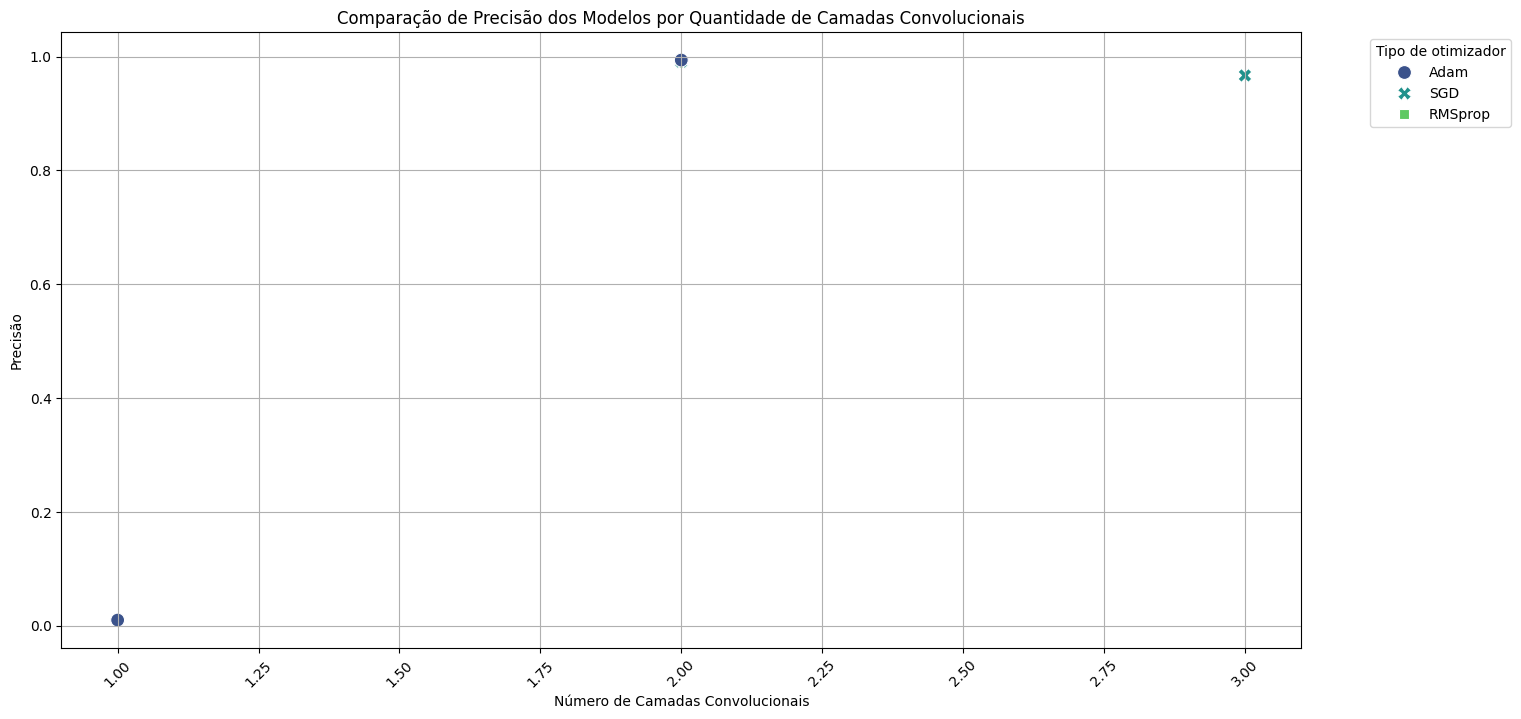

In [32]:
plt.figure(figsize=(16, 8))

sns.scatterplot(data=df, x='params_num_conv_layers', y='user_attrs_precision', hue='params_optimizer', style='params_optimizer', markers=True,
                palette='viridis', s=100)

plt.title('Comparação de Precisão dos Modelos por Quantidade de Camadas Convolucionais')
plt.xlabel('Número de Camadas Convolucionais')
plt.ylabel('Precisão')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Tipo de otimizador', bbox_to_anchor=(1.05, 1), loc='upper left')  # Movendo a legenda para fora do gráfico

plt.show()

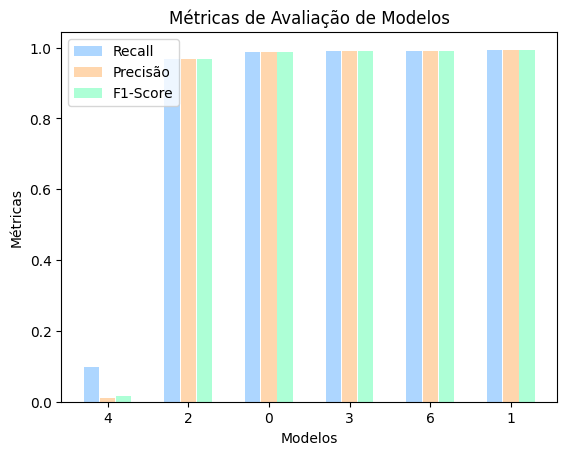

In [35]:
x = np.arange(len(df['number']))
width = 0.2  # Largura das barras

fig, ax = plt.subplots()
bars1 = ax.bar(x - width, df['user_attrs_recall'], width - 0.01, label='Recall', color=(0.6, 0.8, 1.0, 0.8))
bars2 = ax.bar(x, df['user_attrs_precision'], width - 0.01, label='Precisão', color=(1.0, 0.8, 0.6, 0.8))
bars3 = ax.bar(x + width, df['user_attrs_f1_score'], width - 0.01, label='F1-Score', color=(0.6, 1.0, 0.8, 0.8))

ax.set_xlabel('Modelos')
ax.set_ylabel('Métricas')
ax.set_title('Métricas de Avaliação de Modelos')
ax.set_xticks(x)
ax.set_xticklabels(df['number'])
ax.legend()